Implementing the famous "Denoising Diffusion Probabilistic Models" paper which caused the spark that resulted in the fire of image generation models that we see and use today.

# The Math of DDPM

A diffusion probabilistic model (called diffusion model for brevity) consists of a forward process (also called the diffusion process) and a backward process.
![](ddpm.png)

(image source: [DDPM](https://arxiv.org/abs/2006.11239) paper)

## Forward process

In the forward pass Gaussian noise is gradually added to the data according to a variance schedule $\beta_{1},\cdots,\beta_{T}$. The noise added increases with the timestep $t$ that is, $\beta_{t}$ increases with $t$.  
The conditional noise is given by:
$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t-1}, \beta_tI)
$$
, where $\sqrt{1-\beta_t}x_{t-1}$ is the mean and $\beta_tI$ is the variance.
The above equation allows us to sample $x_{t}$ at any timestep $t$.
Define $\alpha_t=1-\beta_{t}$ and $\bar{\alpha}_t  = \prod_{s=1}^{t}\alpha_s$. Then,
$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{\bar{\alpha_t}} x_0, (1-\bar{\alpha_t})I)
$$

## Reverse Process

In the reverse process, we estimate:
$$
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \boldsymbol{\mu}_\theta(x_t, t), \boldsymbol{\Sigma}_\theta(x_t, t))
$$ 
,where $\boldsymbol{\mu_\theta}$ and $\boldsymbol{\Sigma}_\theta$ are neural nets that take in the noised inputs $x_t$ and the timestep $t$ as the inputs and $\theta$ are the model weights. In DDPM however, $\boldsymbol{\Sigma}_\theta$ is ignored and treated as a $\beta_t$ dependent timestep.

$\boldsymbol{\mu_\theta}$ can be reparametrized as
$$
\boldsymbol{\mu_\theta}(x_t, t) = \frac{1}{\sqrt{\alpha}_t}\bigg(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t, t)\bigg)
$$
, where $\epsilon_\theta$ is the neural net that predicts noise from $x_t$. In diffusion models, a unet architecture is used for predicting noise.

We can reparametrize $x_t$ as:
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon
$$
, where $\epsilon \sim \mathcal{N}(0, I)$.

The loss function is simply a MSE loss given by:
$$
L(\theta) := \mathbb{E}_{t,x_0, \epsilon}\bigg[||\epsilon - \epsilon_0(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t) ||^2\bigg]
$$

As described in the paper, $x_0$ can be approximated as:
$$
x_0 \approx \hat{x}_0 = (x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_{\theta}(x_t))/\sqrt{\bar{\alpha}_t}
$$

To sample $x_{t-1}\sim p_\theta(x_{t-1}|x_t)$:
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\bigg(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_\theta(x_t, t)\bigg) + \sigma_t z
$$
, where $z \sim \mathcal{N}(0, I)$

## Training Algorithm
1. repeat
2. $x_0 \sim q(x_0)$
3. $t \sim Uniform({1, \cdots, T})$
4. $\epsilon \sim \mathcal{N}(0, I)$
5. Take gradient descent step on
    $\nabla_\theta||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t)||^2$
6. until converged

## Sampling Algorithm
1. $x_t \sim \mathcal{N}(0, I)$
2. for $t=T, \cdots, 1$ do
3. $z \sim\mathcal{N}(0, I)$ if $t>1$ else $z=0$
4. $x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\bigg(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_\theta(x_t, t)\bigg) + \sigma_t z$
5. end for
6. return $x_0$

# Denoising Diffusion Probabalistic Models with little_ai

Now, let's implement the math above in code (using the [Learner framework](https://github.com/darkknightxi/little_ai/blob/main/little_ai/learner.py) of the [little_ai](https://github.com/darkknightxi/little_ai) library).

Let's begin by importing the necessary libraries

## Import

In [6]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from little_ai.datasets import *
from little_ai.conv import *
from little_ai.learner import *
from little_ai.activations import *
from little_ai.init import *
from little_ai.sgd import *
from little_ai.resnet import *
from little_ai.augment import *

In [7]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

## Load the Dataset

We'll be using the popular fashion-mnist dataset

In [8]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [10]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

## Create model

Unet model is used to predict noise from the image. We'll import the unet model from Diffusers library.

In [11]:
from diffusers import UNet2DModel

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [12]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

# Training with a callback

Let's first define the alphas and betas as discussed in the math section above.

In [13]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

Here's how their plots look like.

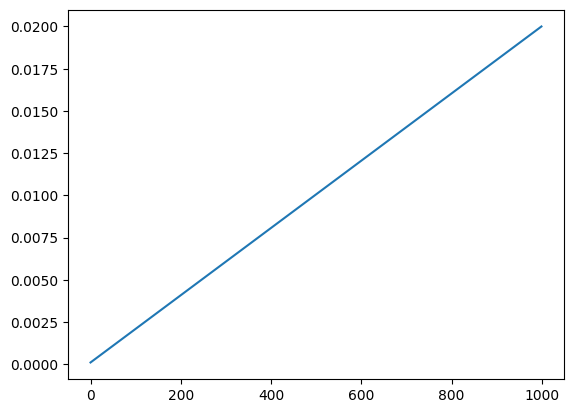

In [14]:
plt.plot(beta);

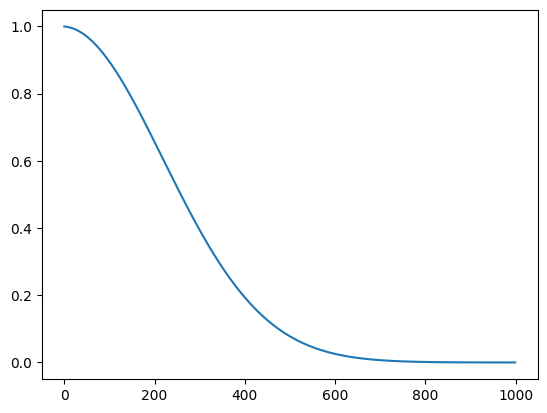

In [15]:
plt.plot(alphabar)

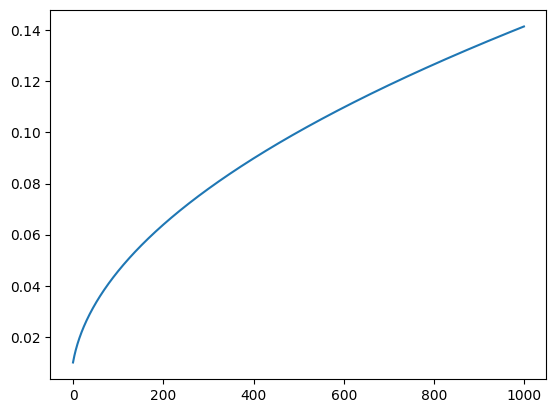

In [16]:
plt.plot(sigma)

The `noisify` function adds Gaussian noise to the input images

In [17]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [18]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([786, 219, 635, 678, 602, 564, 576, 480, 874, 298, 107, 889, 658,  66,
        980, 537,  20, 974, 554, 529, 581, 222, 472, 540, 408])

Here's how some of the images after adding noise look like.

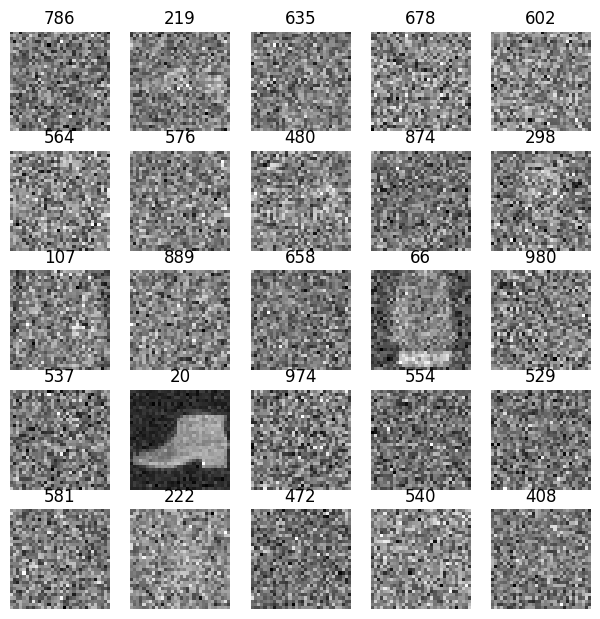

In [19]:
titles = list(map(lambda x: str(x.item()), t))
show_images(xt, imsize=1.5, titles=titles)

In [20]:
from diffusers import UNet2DModel

Now. let's write the `sample` function which does the reverse process of predicting noise as described in the sampling algorithm above.

In [21]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

And now, using the above functions, we create a callback which is compatible with our Learner framework.

In [22]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()

    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

The UNet model typicalluy expects a single input. But in our case, we need to pass in both $x_t$ and $t$. So we modify the `forward` method replacing `x` with `*x`.

In [23]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

Another way of doing this can be to inherit the `TrainCB` class instead of `Callback` as done above and modify the predict method. Then `DDPMCB` class will then look like (`before_batch` and `sample` is same as above):

In [27]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [28]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise
        learn.batch = ((xt, t), ε)

    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

Okay now we're ready to train a model!

Let's create our `Learner`. We'll add our callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

In [29]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

In [30]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

Now let's call the `fit` method.

loss,epoch,train
0.058,0,train
0.024,0,eval
0.022,1,train
0.020,1,eval
0.018,2,train
0.017,2,eval
0.017,3,train
0.016,3,eval
0.016,4,train
0.016,4,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


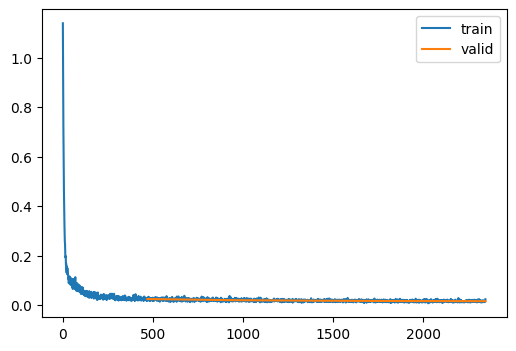

In [31]:
learn.fit(epochs)

# Inference

Now that we've trained our model, let's generate some images with our model:

In [32]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

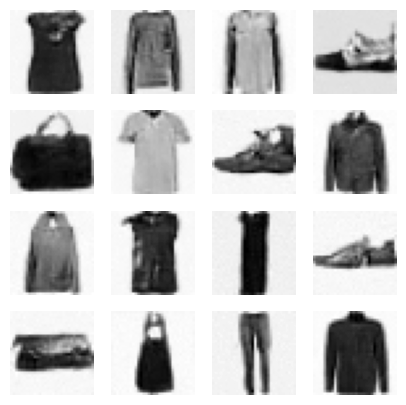

In [33]:
show_images(-samples[-1], figsize=(5,5))